# Beta Grant project analysis

 This notebook analyzes the beta grant application data by using the description of the project.
 It goes through all the project descriptions and calculate readability scores as well as originality and AI detection scores.

 Then boolean are created on various metrics to identify projects that are likely to be fraudulous.
 There are 5 boolean created:

 - 'small-description': True if the description is less than 100 characters, the readability score can not be computed
 - 'low-readability': True if more than 3 metrics are at more than one standard deviation of the mean
 - 'high-originality': True if the originality score is above 0.5
 - 'high-ai': True if the AI score is above 0.5
 - 'to-review': True if the project is flagged by at least one of the previous booleans

Then the projects flaged to-review are analyzed in more details to identify the ones that are likely to be fraudulous.
This analysis is separated from this notebook


In [2]:
# Import needed libraries
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import requests
from readability import Readability

In [3]:
# Set path to data folder
current_dir = Path(os.getcwd())
path_to_data = os.path.join(current_dir.parent.parent, 'data')

In [4]:
# Read grants data
df_grants = pd.read_csv(os.path.join(path_to_data, 'Beta-applicants-projects.csv'))

In [76]:
df_grants.columns

Index(['id', 'projectNumber', 'roundId', 'status', 'amountUSD', 'votes',
       'uniqueContributors', 'payoutAddress', 'metadata.signature',
       'metadata.application.round', 'metadata.application.recipient',
       'metadata.application.project.lastUpdated',
       'metadata.application.project.createdAt',
       'metadata.application.project.id', 'metadata.application.project.title',
       'metadata.application.project.description',
       'metadata.application.project.website',
       'metadata.application.project.bannerImg',
       'metadata.application.project.logoImg',
       'metadata.application.project.metaPtr.protocol',
       'metadata.application.project.metaPtr.pointer',
       'metadata.application.project.userGithub',
       'metadata.application.project.projectGithub',
       'metadata.application.project.projectTwitter',
       'metadata.application.project.credentials.twitter.@context',
       'metadata.application.project.credentials.twitter.type',
       'metada

In [77]:
df_grants.shape

(538, 53)

In [5]:
df_grants.head(2)

,id,projectNumber,roundId,status,amountUSD,votes,uniqueContributors,payoutAddress,metadata.signature,metadata.application.round,...,metadata.application.project.credentials.github.credentialSubject.@context,metadata.application.project.credentials.github.issuer,metadata.application.project.credentials.github.issuanceDate,metadata.application.project.credentials.github.proof.type,metadata.application.project.credentials.github.proof.proofPurpose,metadata.application.project.credentials.github.proof.verificationMethod,metadata.application.project.credentials.github.proof.created,metadata.application.project.credentials.github.proof.jws,metadata.application.project.credentials.github.expirationDate,metadata.application.answers
0,0x6aeb3ddab061203d32594b03901bf458679a66fbeab9...,355.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x4c3db176694bdfc0f9e4a04738205d562ef31a026699...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,"[{'hash': 'https://schema.org/Text', 'provider...",did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...,2023-04-12T09:48:40.402Z,Ed25519Signature2018,assertionMethod,did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...,2023-04-12T09:48:40.402Z,eyJhbGciOiJFZERTQSIsImNyaXQiOlsiYjY0Il0sImI2NC...,2023-07-11T09:48:40.402Z,"[{'questionId': 0, 'question': 'Email Address'..."
1,0xdeffc2d190ddec88d06ba86e1eb09abe5a9ccb49ab1d...,174.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0xc9f5e29fcb4db0b0c9a5909f68c162ea5d16a275f705...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,"[{'hash': 'https://schema.org/Text', 'provider...",did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...,2023-01-13T08:12:23.363Z,Ed25519Signature2018,assertionMethod,did:key:z6MkghvGHLobLEdj1bgRLhS4LPGJAvbMA1tn2z...,2023-01-13T08:12:23.363Z,eyJhbGciOiJFZERTQSIsImNyaXQiOlsiYjY0Il0sImI2NC...,2023-04-13T08:12:23.363Z,"[{'questionId': 0, 'question': 'Email Address'..."


In [80]:
df_grants['metadata.application.project.description'].head()

0    [DAOstar](https://daostar.org) is the standard...
1    # We show you how to manage and monetize your ...
2    # Aurellion: Decentralized Shipping Platform\n...
3    beaconcha.in is an open source explorer that p...
4    xLog is the best on-chain and open-source blog...
Name: metadata.application.project.description, dtype: object

In [82]:
# reproducing url is not possible
def get_gitcoin_url(roundId, project_id):
    return f'https://explorer.gitcoin.co/#/round/1/{roundId}/{roundId}-{project_id}'
# https://explorer.gitcoin.co/#/round/1/0x12bb5bbbfe596dbc489d209299b8302c3300fa40/0x12bb5bbbfe596dbc489d209299b8302c3300fa40-50

In [83]:
df_rounds = pd.read_csv(os.path.join(path_to_data, 'all-rounds.csv'))

In [84]:
def merge_drop_duplicates(df_rounds, df_grant, cols_to_keep):
    # merge to get the rounds and then drop duplicates but gather the round names in a list
    df = df_rounds.merge(df_grant, left_on='Round ID', right_on='roundId')[cols_to_keep]
    agg_rounds = pd.DataFrame(df.groupby('metadata.application.project.title')['Round name'].unique()).reset_index()
    df.drop('Round name', axis=1, inplace=True)
    df = df.merge(agg_rounds, on='metadata.application.project.title')
    df.drop_duplicates(subset=['metadata.application.project.title'], inplace=True)
    #sort by round name
    df.sort_values(by=['roundId'], inplace=True)
    df['numRounds'] = df['Round name'].apply(lambda x: len(x))
    df.drop('Total projects', axis=1, inplace=True)
    return df

In [85]:
df_grants.shape

(538, 53)

In [86]:
cols_to_keep = df_grants.columns.to_list() + df_rounds.columns.to_list()
df_grants = merge_drop_duplicates(df_rounds, df_grants, cols_to_keep=cols_to_keep)

In [87]:
df_grants.shape

(426, 56)

In [88]:
def flesch_kincaid(r):
    try:
        return r.flesch_kincaid().score
    except:
        return np.nan

def flesch(r):
    try:
        return r.flesch().score
    except:
        return np.nan

def gunning_fog(r):
    try:
        return r.gunning_fog().score
    except:
        return np.nan

def coleman_liau(r):
    try:
        return r.coleman_liau().score
    except:
        return np.nan

def dale_chall(r):
    try:
        return r.dale_chall().score
    except:
        return np.nan

def ari(r):
    try:
        return r.ari().score
    except:
        return np.nan

def linsear_write(r):
    try:
        return r.linsear_write().score
    except:
        return np.nan

def smog(r):
    try:
        return r.smog().score
    except:
        return np.nan

def spache(r):
    try:
        return r.spache().score
    except:
        return np.nan


In [89]:
def flesch_kincaid_grade(r):
    try:
        return r.flesch_kincaid().grade_level
    except:
        return np.nan

def flesch_grade(r):
    try:
        return r.flesch().grade_levels[0]
    except:
        return np.nan

def gunning_fog_grade(r):
    try:
        return r.gunning_fog().grade_level
    except:
        return np.nan

def coleman_liau_grade(r):
    try:
        return r.coleman_liau().grade_level
    except:
        return np.nan

def dale_chall_grade(r):
    try:
        return r.dale_chall().grade_levels[0]
    except:
        return np.nan

def ari_grade(r):
    try:
        return r.ari().grade_levels[0]
    except:
        return np.nan

def linsear_write_grade(r):
    try:
        return r.linsear_write().grade_level
    except:
        return np.nan

def smog_grade(r):
    try:
        return r.smog().grade_levels[0]
    except:
        return np.nan

def spache_grade(r):
    try:
        return r.spache().grade_level
    except:
        return np.nan


In [90]:
df_grants['readability'] = df_grants['metadata.application.project.description'].apply(lambda x: Readability(x))

In [91]:
df_grants['flesch_kincaid'] = df_grants['readability'].apply(flesch_kincaid)
df_grants['flesch_kincaid_grade'] = df_grants['readability'].apply(flesch_kincaid_grade)
df_grants['flesch'] = df_grants['readability'].apply(flesch)
df_grants['flesch_grade'] = df_grants['readability'].apply(flesch_grade)
df_grants['gunning_fog'] =  df_grants['readability'].apply(gunning_fog)
df_grants['gunning_fog_grade'] = df_grants['readability'].apply(gunning_fog_grade)
df_grants['coleman_liau'] = df_grants['readability'].apply(coleman_liau)
df_grants['coleman_liau_grade'] = df_grants['readability'].apply(coleman_liau_grade)
df_grants['dale_chall'] = df_grants['readability'].apply(dale_chall)
df_grants['dale_chall_grade'] = df_grants['readability'].apply(dale_chall_grade)
df_grants['ari'] = df_grants['readability'].apply(ari)
df_grants['ari_grade'] = df_grants['readability'].apply(ari_grade)
df_grants['linsear_write'] =   df_grants['readability'].apply(linsear_write)
df_grants['linsear_write_grade'] = df_grants['readability'].apply(linsear_write_grade)
df_grants['smog'] = df_grants['readability'].apply(smog)
df_grants['smog_grade'] = df_grants['readability'].apply(smog_grade)
df_grants['spache'] = df_grants['readability'].apply(spache)
df_grants['spache_grade'] = df_grants['readability'].apply(spache_grade)

In [92]:
scores = ['flesch_kincaid', 'flesch', 'gunning_fog', 'coleman_liau', 'dale_chall', 'ari', 'linsear_write', 'smog', 'spache']
grades = ['flesch_kincaid_grade', 'flesch_grade', 'gunning_fog_grade', 'coleman_liau_grade', 'dale_chall_grade', 'ari_grade', 'linsear_write_grade', 'smog_grade', 'spache_grade']
df_grants[scores].describe()

,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,94.000000,343.000000
mean,14.470951,29.717575,15.647387,15.756035,11.652825,16.244507,16.054388,15.332871,8.405843
std,4.336349,19.450052,4.211656,4.298309,1.527509,5.932009,7.137230,2.216299,1.529918
min,7.014481,-136.882619,7.029650,7.325664,8.565106,6.417059,4.620690,9.807559,5.531486
25%,11.868035,19.989836,13.273461,12.980971,10.756765,12.743224,12.463294,13.993250,7.456925
50%,14.011333,31.858776,14.991420,15.067345,11.537651,15.461584,14.952381,15.112172,8.168254
75%,16.364653,42.669877,17.633418,17.576227,12.406057,18.979645,18.242647,16.847623,9.064913
max,61.280952,71.837576,56.225641,40.345489,20.542793,79.892766,101.333333,20.798641,24.704143


Lets normalize the readabilty scores

In [93]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_grants[scores] = scaler.fit_transform(df_grants[scores])

In [94]:
df_grants[scores].describe()

,flesch_kincaid,flesch,gunning_fog,coleman_liau,dale_chall,ari,linsear_write,smog,spache
count,3.430000e+02,3.430000e+02,3.430000e+02,3.430000e+02,3.430000e+02,3.430000e+02,3.430000e+02,9.400000e+01,3.430000e+02
mean,-1.864398e-16,1.696084e-16,1.450087e-16,8.804101e-17,3.107330e-16,-4.557417e-16,3.003752e-16,-6.614095e-17,-1.864398e-16
std,1.001461e+00,1.001461e+00,1.001461e+00,1.001461e+00,1.001461e+00,1.001461e+00,1.001461e+00,1.005362e+00,1.001461e+00
min,-1.722039e+00,-8.578053e+00,-2.049153e+00,-1.964188e+00,-2.024361e+00,-1.659101e+00,-1.604320e+00,-2.506403e+00,-1.881509e+00
25%,-6.011321e-01,-5.008702e-01,-5.644797e-01,-6.465610e-01,-5.874718e-01,-5.910980e-01,-5.038846e-01,-6.076819e-01,-6.211469e-01
50%,-1.061467e-01,1.102479e-01,-1.559779e-01,-1.604575e-01,-7.550965e-02,-1.321756e-01,-1.546281e-01,-1.001142e-01,-1.555220e-01
75%,4.373423e-01,6.668992e-01,4.722448e-01,4.240856e-01,4.938318e-01,4.617549e-01,3.070458e-01,6.871248e-01,4.314168e-01
max,1.081057e+01,2.168711e+00,9.648827e+00,5.729085e+00,5.828413e+00,1.074530e+01,1.196592e+01,2.479393e+00,1.066862e+01


In [95]:
df_grants[grades].dtypes

flesch_kincaid_grade     object
flesch_grade             object
gunning_fog_grade        object
coleman_liau_grade       object
dale_chall_grade         object
ari_grade                object
linsear_write_grade      object
smog_grade              float64
spache_grade             object
dtype: object

In [96]:
df_grants[grades].describe()

,smog_grade
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [97]:
# remove columns with all null values
new_grades = df_grants[grades].columns[df_grants[grades].isnull().sum() != df_grants.shape[0]].to_list()
new_grades

['flesch_kincaid_grade',
 'flesch_grade',
 'gunning_fog_grade',
 'coleman_liau_grade',
 'dale_chall_grade',
 'ari_grade',
 'linsear_write_grade',
 'spache_grade']

In [98]:
df_grants[new_grades].describe()

,flesch_kincaid_grade,flesch_grade,gunning_fog_grade,coleman_liau_grade,dale_chall_grade,ari_grade,linsear_write_grade,spache_grade
count,343,343,343,343,343,343,343,343
unique,20,5,8,25,3,8,33,9
top,15,college_graduate,college,14,college_graduate,college_graduate,13,8
freq,46,154,160,46,306,247,39,124


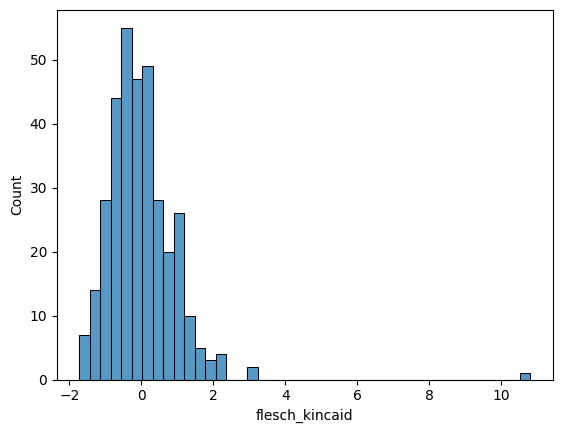

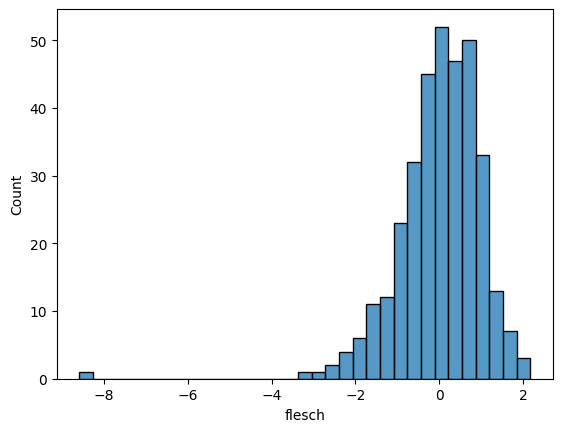

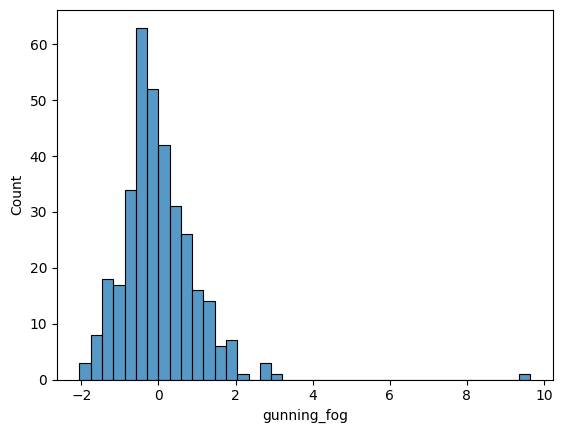

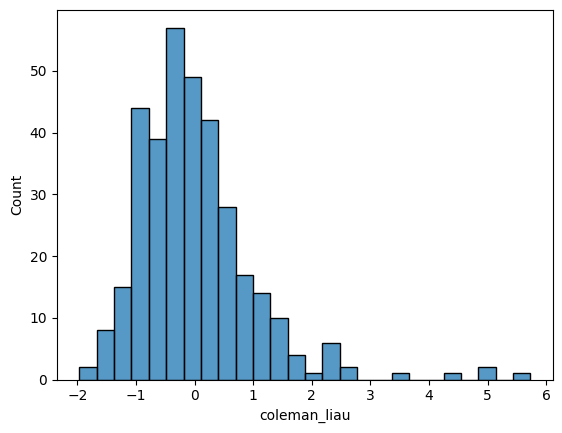

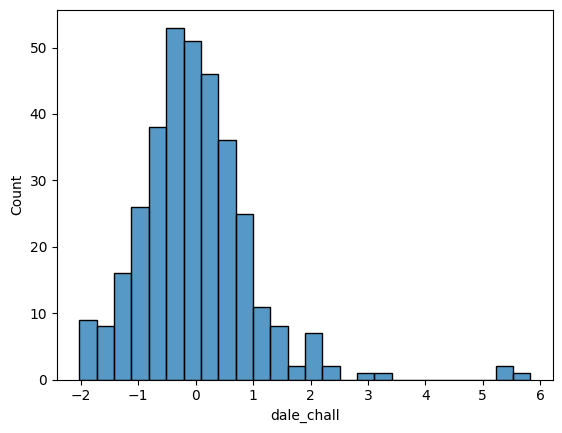

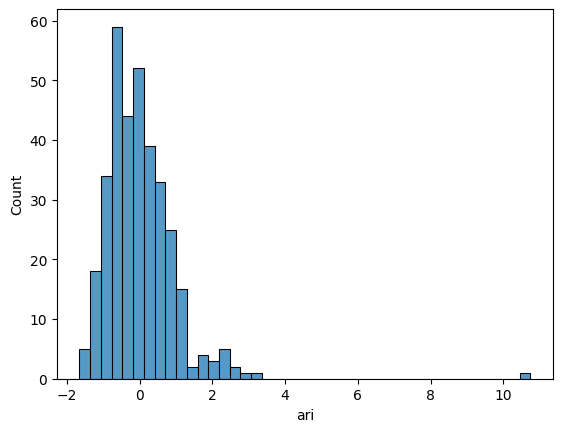

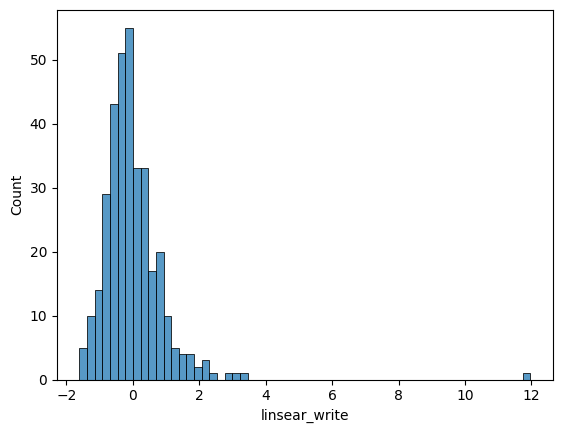

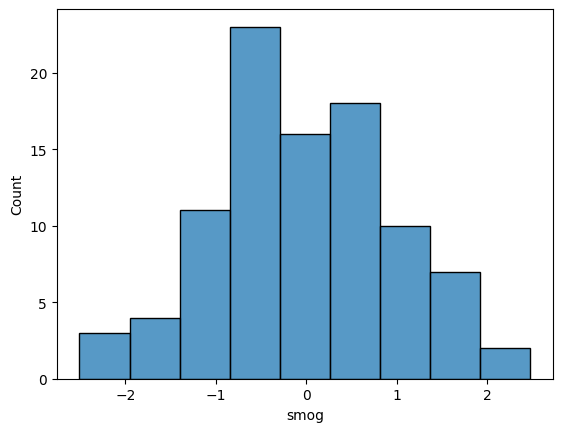

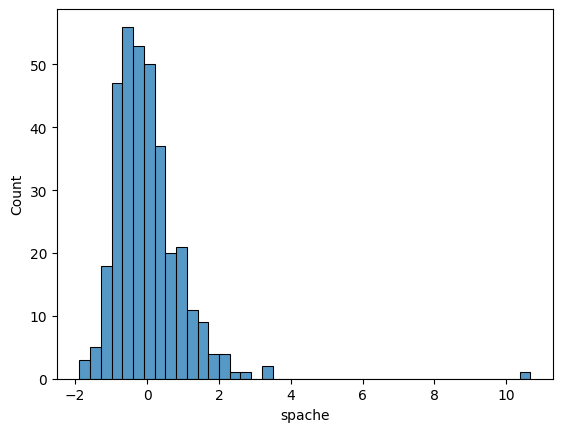

In [99]:
from matplotlib import pyplot as plt
for metric in scores:
    plt.figure()
    sns.histplot(df_grants[metric].dropna())

These metrics have a gaussian distribution thus we try to look at outliers to see which grants are the most difficult to read.

In [100]:
# for metric in grades:
#     plt.figure()
#     sns.histplot(df_grants[metric].dropna())

In [101]:
df_grants[scores].isna().sum()

flesch_kincaid     83
flesch             83
gunning_fog        83
coleman_liau       83
dale_chall         83
ari                83
linsear_write      83
smog              332
spache             83
dtype: int64

By extracting the grants where the readability score can not be computed there are already 96 grants to review.

In [102]:
# extract grants with nan values
df_not_readable = df_grants[df_grants[scores].isna().sum(axis=1) > 1]
df_not_readable.head()

,id,projectNumber,roundId,status,amountUSD,votes,uniqueContributors,payoutAddress,metadata.signature,metadata.application.round,...,dale_chall,dale_chall_grade,ari,ari_grade,linsear_write,linsear_write_grade,smog,smog_grade,spache,spache_grade
0,0x6aeb3ddab061203d32594b03901bf458679a66fbeab9...,355.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x4c3db176694bdfc0f9e4a04738205d562ef31a026699...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0x4fb782cbfdc36ab366700e5f49b88a14358cf074299d...,363.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x11ca7c308274c59d7016e5fe4ecdbea3b685d29b23eb...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,0x474eff6770dca06e396e2c56e023418f69f44da1034c...,248.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x86b0641777175a6bc4eeab5ae0c9f7dae0e656bb54d7...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,0xc81e44641b8ee3e3f22594925c809fa2a9813586aaff...,NaN,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x17426d904ca14cdc76c395e50285e5e5fa071e7af328...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,0x8df4998885bf72d0e1b446216f66ee2152a7d5fe931d...,545.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x1ea9956e0899cbee5ceb9cbc806a56da355beac5a1c8...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df_not_readable.to_csv('../not_readable.csv')

Lets investigate outliers that have readability values
6 sigma or more away from the mean is often considered to be outliers where sigma is the standard deviation.

In [104]:
df_readable = df_grants[df_grants[scores].isna().sum(axis=1) <= 1]

In [105]:
# Compute 6 sigma for each metric and extract grants with values outside 6 sigma
# After trying only two grants where above 6 sigma for one metric, I decided to use 5 sigma instead
df_outliers = df_grants[(df_grants[scores].abs() > 5).sum(axis=1) > 0]


In [106]:
df_outliers

,id,projectNumber,roundId,status,amountUSD,votes,uniqueContributors,payoutAddress,metadata.signature,metadata.application.round,...,dale_chall,dale_chall_grade,ari,ari_grade,linsear_write,linsear_write_grade,smog,smog_grade,spache,spache_grade
57,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,67.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x448caa2ff3f0bf08bdfea75db161cf6fe449f1411ee2...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,1.420658,college_graduate,2.597332,college_graduate,-1.309673,7,-2.506403,NaN,-0.067248,8
394,0x092a5b983ddfa82321a09680e982bd31894c2f9f794f...,299.0,0x421510312C40486965767be5Ea603Aa8a5707983,PENDING,0,0,0,NaN,0x058123a90b0176c6bb5c50c881b3889fc60388835802...,0x421510312c40486965767be5ea603aa8a5707983,...,5.435734,college_graduate,0.059880,college_graduate,0.442546,19,2.166063,NaN,2.159270,12
396,0x14e88e69d4685850ba11b2fa1eb11716a1ccbeade045...,390.0,0x421510312C40486965767be5Ea603Aa8a5707983,PENDING,0,0,0,NaN,0x5b4db4a203b23e220bcf4eab8191b74822fdb0b4b144...,0x421510312c40486965767be5ea603aa8a5707983,...,5.371739,college_graduate,0.871696,college_graduate,-0.049726,16,NaN,NaN,1.863355,11
214,0x92980c994e3e4fda7f66cefa230b7220913c8175833b...,353.0,0xAA40E2E5c8df03d792A52B5458959C320F86ca18,PENDING,0,0,0,NaN,0x0aa33fb93022b49e0c34bd4efb4d09d84f4dade92e7e...,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,...,5.828413,college_graduate,10.745304,college_graduate,11.965921,101,NaN,NaN,10.668615,25
356,0x98764e18e010faaab515ca399ba347951353c2a8ed4c...,NaN,0xAA40E2E5c8df03d792A52B5458959C320F86ca18,PENDING,0,0,0,NaN,0x94f59cb84846105d2289eb3335392ef0d0e2b41c3beb...,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,...,-0.084487,college_graduate,3.201510,college_graduate,0.296385,18,-0.059050,NaN,0.241598,9


In [107]:
df_outliers.to_csv('../outliers.csv')

In [112]:
small_colums = ['roundId', 'metadata.application.project.title', 'status', 'metadata.application.project.website', 'metadata.application.project.projectTwitter', 'metadata.application.project.userGithub','metadata.application.project.projectGithub', 'metadata.application.recipient', 'payoutAddress']

In [114]:
df_outlier_col = df_outliers.loc[:, small_colums]
df_outlier_col.head(2)

,roundId,metadata.application.project.title,metadata.application.project.website,metadata.application.project.projectTwitter,metadata.application.project.userGithub,metadata.application.project.projectGithub,metadata.application.recipient,payoutAddress
57,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,POAPin,https://poap.in,glorylaboratory,RockerFlower,glorylab,0x5Afc7720b161788f9D833555b7EbC3274FD98Da1,NaN
394,0x421510312C40486965767be5Ea603Aa8a5707983,Fundación Tucultura,https://tucultura.co/,tuculturactg,NaN,NaN,0xd3F0F07E1C4068B9e80FD641599324f5a768F10B,NaN


In [115]:
df_outlier_col.to_csv('../outliers_small.csv', index=False)

In [117]:
df_not_readable_col = df_not_readable.loc[:, small_colums]

In [118]:
df_not_readable_col.head(2)

,roundId,metadata.application.project.title,metadata.application.project.website,metadata.application.project.projectTwitter,metadata.application.project.userGithub,metadata.application.project.projectGithub,metadata.application.recipient,payoutAddress
0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,DAOstar,https://daostar.org,daostar_one,metagov,metagov,0xfF2aBEF3af9655D96Da983916e066134adea6390,NaN
116,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,Test,https://www.testing.dev,_lolu,jesuloluwao,lolus-test,0x69f9e121702461eA52F627A6147ea3c6dc2DEF31,NaN


In [119]:
df_not_readable_col.to_csv('../not_readable_small.csv', index=False)

In [126]:
# Compute 6 sigma for each metric and extract grants with values outside 6 sigma
# After trying only two grants where above 6 sigma for one metric, I decided to use 5 sigma instead
df_outliers_2 = df_grants[(df_grants[scores].abs() > 4).sum(axis=1) > 1]

In [147]:
df_grants_no_nan = df_grants.dropna(subset=scores, axis=0)

In [152]:
df_grants_no_nan[(df_grants_no_nan[scores].abs() > 1).sum(axis=1) > 3].shape

(12, 75)

In [158]:
df_side = df_grants_no_nan[(df_grants_no_nan[scores].abs() > 1).sum(axis=1) > 3]

In [159]:
df_side

,id,projectNumber,roundId,status,amountUSD,votes,uniqueContributors,payoutAddress,metadata.signature,metadata.application.round,...,dale_chall,dale_chall_grade,ari,ari_grade,linsear_write,linsear_write_grade,smog,smog_grade,spache,spache_grade
111,0x34538dc3eff7eedd3df295980c16b7514c9b126892d4...,NaN,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0xd39caa7af1007933f1e52aae8f38d30373076bd9ef36...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,1.115673,college_graduate,1.085308,college_graduate,0.781641,22,1.839433,NaN,1.048439,10
121,0x4cd41869f9b2d95c05e2cb13643f1ab7ae05ebd43934...,70.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x27f75c194ea762196df52e8dedb19d0275ac7ab6e67b...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,-1.069734,college_graduate,-0.946877,11,-1.008660,9,-0.948755,NaN,-1.339806,6
129,0xacb31ada8903946dd25427b1ec41b1dda9ba8c218dd5...,553.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x1f06d88c72866f839aabdffd58eaf202aabc818df1cf...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,-0.608454,college_graduate,-1.078284,10,-0.804014,10,-1.438493,NaN,-0.756774,7
57,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,67.0,0x12BB5bBbFE596dbc489d209299B8302c3300fa40,PENDING,0,0,0,NaN,0x448caa2ff3f0bf08bdfea75db161cf6fe449f1411ee2...,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,...,1.420658,college_graduate,2.597332,college_graduate,-1.309673,7,-2.506403,NaN,-0.067248,8
394,0x092a5b983ddfa82321a09680e982bd31894c2f9f794f...,299.0,0x421510312C40486965767be5Ea603Aa8a5707983,PENDING,0,0,0,NaN,0x058123a90b0176c6bb5c50c881b3889fc60388835802...,0x421510312c40486965767be5ea603aa8a5707983,...,5.435734,college_graduate,0.059880,college_graduate,0.442546,19,2.166063,NaN,2.159270,12
417,0xaefb6b82af41c82e4bf3f08150254363fac89efbef48...,423.0,0x421510312C40486965767be5Ea603Aa8a5707983,PENDING,0,0,0,NaN,0x251f993f285d9767ec8768832fd2bfee070690298187...,0x421510312c40486965767be5ea603aa8a5707983,...,1.315427,college_graduate,-0.083233,college_graduate,-1.371026,6,-1.721421,NaN,-0.414607,8
467,0x579ab08cf9564b84316540af2e97c022a74d9e0f1f80...,588.0,0x421510312C40486965767be5Ea603Aa8a5707983,PENDING,0,0,0,NaN,0xbc9fb72863f9275ca2591b7ceedd86110513ef5c7908...,0x421510312c40486965767be5ea603aa8a5707983,...,1.686568,college_graduate,1.657817,college_graduate,1.029480,23,1.701564,NaN,1.466758,11
488,0xf12b7bb36afb9bb9763835bcdf91e69302a683678d06...,582.0,0x8aA06b3b8cAc2970857F4E0fD78F21dc01AAdE94,PENDING,0,0,0,NaN,0x0912e25bd6291a961f55402049a8d98bea8f13227339...,0x8aa06b3b8cac2970857f4e0fd78f21dc01aade94,...,0.893625,college_graduate,2.011020,college_graduate,0.874676,22,2.479393,NaN,0.898421,10
266,0x1e84545865da4aa1be2a34ac7fdc4eb30d6ae9efb396...,26.0,0xAA40E2E5c8df03d792A52B5458959C320F86ca18,PENDING,0,0,0,NaN,0xfe8e8ae36af44f55b15c978e303ab4c848751e36a002...,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,...,-1.701493,college,-0.961875,11,-0.682128,11,-1.225500,NaN,-1.305041,6
312,0x3deaf0fd52dc5e6eb6062c9b620eb0b3029c10ee6b77...,NaN,0xAA40E2E5c8df03d792A52B5458959C320F86ca18,PENDING,0,0,0,NaN,0xb76e1321ec4b070c44975b0e5fe45f7c834c59c2ff2b...,0xaa40e2e5c8df03d792a52b5458959c320f86ca18,...,0.478075,college_graduate,0.957056,college_graduate,1.465677,26,1.369173,NaN,1.358085,10


In [174]:
## extract all project description into one string
len(df_grants_no_nan['metadata.application.project.description'].str.cat(sep=' ').split(' '))

95044

In [177]:
95044/100*0.01

9.5044

In [179]:
df_grants_no_nan['metadata.application.project.title'].iloc[0]

'zenbit.eth'

In [180]:
df_grants_no_nan['metadata.application.project.description'].iloc[0]

'Zenbit.eth is a digital lab that enhances urban coordination and utility by promoting the development of public goods. Founded in 2019, it introduces Web3 Cities as an alternative to smart cities, focusing on customized city design, creating digital public goods, and regenerating urban spaces. Based on these pillars, Zenbit.eth has identified four key user experiences to create a modular urban data system: digitizing data in public spaces, coordinating urban governance activities, decentralized e-commerce, and incentivizing emission-free mobility and logistics. Collaborating with global talent through ETH Global hackathons[¹](https://app.poap.xyz/scan/zenbit.eth), Zenbit.eth has implemented and tested various public goods and prototypes in Mexico, Colombia, and the United States.\n\nWe are committed to the development of public and open-source projects, with a strong focus on design and development principles. To ensure the sustainability of their efforts, Zenbit has actively particip

In [186]:
ORIGINALITY_API_KEY = 'jmy7dahqfwpl68r053uvn9z2kxbets4g'

In [187]:


url = 'https://api.originality.ai/api/v1/scan/ai'
headers = {
    'Content-Type': 'application/json',
    'X-OAI-API-KEY': ORIGINALITY_API_KEY
}
data = {
  "title": df_grants_no_nan['metadata.application.project.title'].iloc[0],
  "content": df_grants_no_nan['metadata.application.project.description'].iloc[0]
}

# Make a POST request to the API endpoint
response = requests.post(url, headers=headers, json=data)

# Check if the response was successful (HTTP status code 200)
if response.status_code == 200:
    if response.json().get('success'):
        output = response.json().get('score')
else:
    # If the response was unsuccessful, print the status code and reason
    print('Request failed with status code:', response.status_code)
    print('Reason:', response.reason)
    print('Request response:', response.text)
    

b'{"success":true,"title":"zenbit.eth","score":{"original":0.55825,"ai":0.44175},"blocks":[{"text":"Zenbit.eth is a digital lab that enhances urban coordination and utility by promoting the development of public goods. Founded in 2019, it introduces Web3 Cities as an alternative to smart cities, focusing on customized city design, creating digital public goods, and regenerating urban spaces. Based on these pillars, Zenbit.eth has identified four key user experiences to create a modular urban data system: digitizing data in public spaces, coordinating urban governance activities, decentralized e-commerce, and incentivizing emission-free mobility and logistics. Collaborating with global talent through ETH Global hackathons[\\u00b9](https:\\/\\/app.poap.xyz\\/scan\\/zenbit.eth), Zenbit.eth has implemented and tested various public goods and prototypes in Mexico, Colombia, and the United States.\\n\\nWe are committed to the development of public and open-source projects, with a strong focu

In [195]:
if response.json().get('success'):
    output = response.json().get('score')

print(output)


{'original': 0.55825, 'ai': 0.44175}


In [196]:
output.get('original')

0.55825

In [197]:
def originality_api(title, description):
    url = 'https://api.originality.ai/api/v1/scan/ai'
    headers = {
        'Content-Type': 'application/json',
        'X-OAI-API-KEY': ORIGINALITY_API_KEY
    }
    data = {
      "title": title,
      "content": description
    }
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        if response.json().get('success'):
            output = response.json().get('score')
        else:
            print('Request response:', response.text)
            output = {'original': None, 'ai': None}
    else:
        print('Request failed with status code:', response.status_code)
        print('Reason:', response.reason)
        print('Request response:', response.text)
        output = {'original': None, 'ai': None}
    return output

In [198]:
originality_api(df_grants_no_nan['metadata.application.project.title'].iloc[0], df_grants_no_nan['metadata.application.project.description'].iloc[0])

{'original': 0.55825, 'ai': 0.44175}

In [183]:
response.content

b'{"error":"Invalid API key"}'